# Baseline Model Building

### Mount Google Drive (If on Google Colab)

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

target_folder = "207 Machine Learning: Final Project"
found_path = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if target_folder in dirs:
        found_path = os.path.join(root, target_folder)
        break

if found_path:
    os.chdir(found_path)
    print("Changed working directory to:", os.getcwd())
else:
    print(f"Folder '{target_folder}' not found.")

Mounted at /content/drive
Changed working directory to: /content/drive/.shortcut-targets-by-id/1MnqFmQYij3NcmwhbYUVc-9h4Dp6eLuMH/207 Machine Learning: Final Project


## <span style="color:chocolate">1. Data Preprocessing</span>

### 1.1 Drop Columns
Besides rename and correct the column types, this section examines columns with missing values in the data set.
- `TractID`, `StateName`, `CountyName`, and `GEOID` are dropped because they are categorical variables and not related to the outcome
- `LILA_Urban1_Rural10` is renamed to `IsFoodDesert` as our outcome variable
- Columns with more than 50% missing values are dropped


In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_CODE = 1234

# Read in the data
centroids_data = pd.read_csv("Data/regional_combined_centroids.csv")
centroids_data.drop(columns=['state'], inplace=True)

# Rename the columns
with open("Data/rename.json", 'r') as f:
    rename = json.load(f)

rename_dict = {}
for col in centroids_data.columns:
    if col in rename.keys():
         rename_dict[col] = rename[col]['simplifiedName']

centroids_data.rename(columns=rename_dict, inplace=True)

# Make sure the TractID column is properly converted to string type
centroids_data['TractID'] = centroids_data['TractID'].astype(str).str.zfill(11)

# Pad 10-digit GEOIDs to 11-digit strings
centroids_data['GEOID'] = centroids_data['GEOID'].astype(str).str.zfill(11)

# Define a function to classify tracts as food deserts
def is_food_desert(row):
    return 1 if (row["LILA_Urban1_Rural10"] == 1) else 0

# Create a new column in the DataFrame to indicate food deserts
centroids_data["IsFoodDesert"] = centroids_data.apply(is_food_desert, axis=1)

# Drop unnecessary columns
centroids_data.drop(columns=["TractID", "StateName", "CountyName", "LILA_Urban1_Rural10", "GEOID"], inplace=True)

# Drop columns with more than 50% missing values
row_count, col_count = centroids_data.shape
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df = pd.DataFrame(centroids_data.isnull().sum(),
                      columns=['Missing Value Count'])
    df['Proportion of Missing Values'] = df['Missing Value Count'] / row_count
    cols_to_drop = df[df['Proportion of Missing Values'] > 0.2].index.tolist()
    centroids_data.drop(columns=cols_to_drop, inplace=True)
    print('Dropping columns with more than 50% missing values: ', cols_to_drop)


Dropping columns with more than 50% missing values:  ['LAPop_Urban1_Rural10', 'LAPop_UrbanHalf_Rural10', 'LAPop_Urban1_Rural20', 'LALowIncome_Urban1_Rural10', 'LALowIncome_UrbanHalf_Rural10', 'LALowIncome_Urban1_Rural20', 'LAPop_10Miles', 'LAPopShare_10Miles', 'LALowIncome_10Miles', 'LALowIncomeShare_10Miles', 'LAKids_10Miles', 'LAKidsShare_10Miles', 'LASeniors_10Miles', 'LASeniorsShare_10Miles', 'LAWhite_10Miles', 'LAWhiteShare_10Miles', 'LABlack_10Miles', 'LABlackShare_10Miles', 'LAAsian_10Miles', 'LAAsianShare_10Miles', 'LANHPI_10Miles', 'LANHPIShare_10Miles', 'LAAIAN_10Miles', 'LAAIANShare_10Miles', 'LAMultiracial_10Miles', 'LAMultiracialShare_10Miles', 'LAHispanic_10Miles', 'LAHispanicShare_10Miles', 'LANoVehicle_10Miles', 'LANoVehicleShare_10Miles', 'LASNAP_10Miles', 'LASNAPShare_10Miles', 'LAPop_20Miles', 'LAPopShare_20Miles', 'LALowIncome_20Miles', 'LALowIncomeShare_20Miles', 'LAKids_20Miles', 'LAKidsShare_20Miles', 'LASeniors_20Miles', 'LASeniorsShare_20Miles', 'LAWhite_20Mile

### 1.2 Impute missing data

Since all distributions are originally left or right-skewed, they are sensitive to outliers. Therefore, impute missing values with median.

In [3]:
# Calculate missing value proportions
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df = pd.DataFrame(centroids_data.isnull().sum(),
                      columns=['Missing Value Count'])
    df['Proportion of Missing Values'] = df['Missing Value Count'] / len(centroids_data)
    print(df)

                             Missing Value Count  Proportion of Missing Values
IsUrban                                        0                      0.000000
Pop2010                                        0                      0.000000
OccupiedHousingUnits                           0                      0.000000
HighGroupQuarters                              0                      0.000000
GroupQuartersPopulation                        0                      0.000000
GroupQuartersShare                             0                      0.000000
LILA_UrbanHalf_Rural10                         0                      0.000000
LILA_Urban1_Rural20                            0                      0.000000
LILA_VehicleOr20Miles                          0                      0.000000
LowVehicleAccess                               0                      0.000000
IsLowIncome                                    0                      0.000000
PovertyRate                                    0    

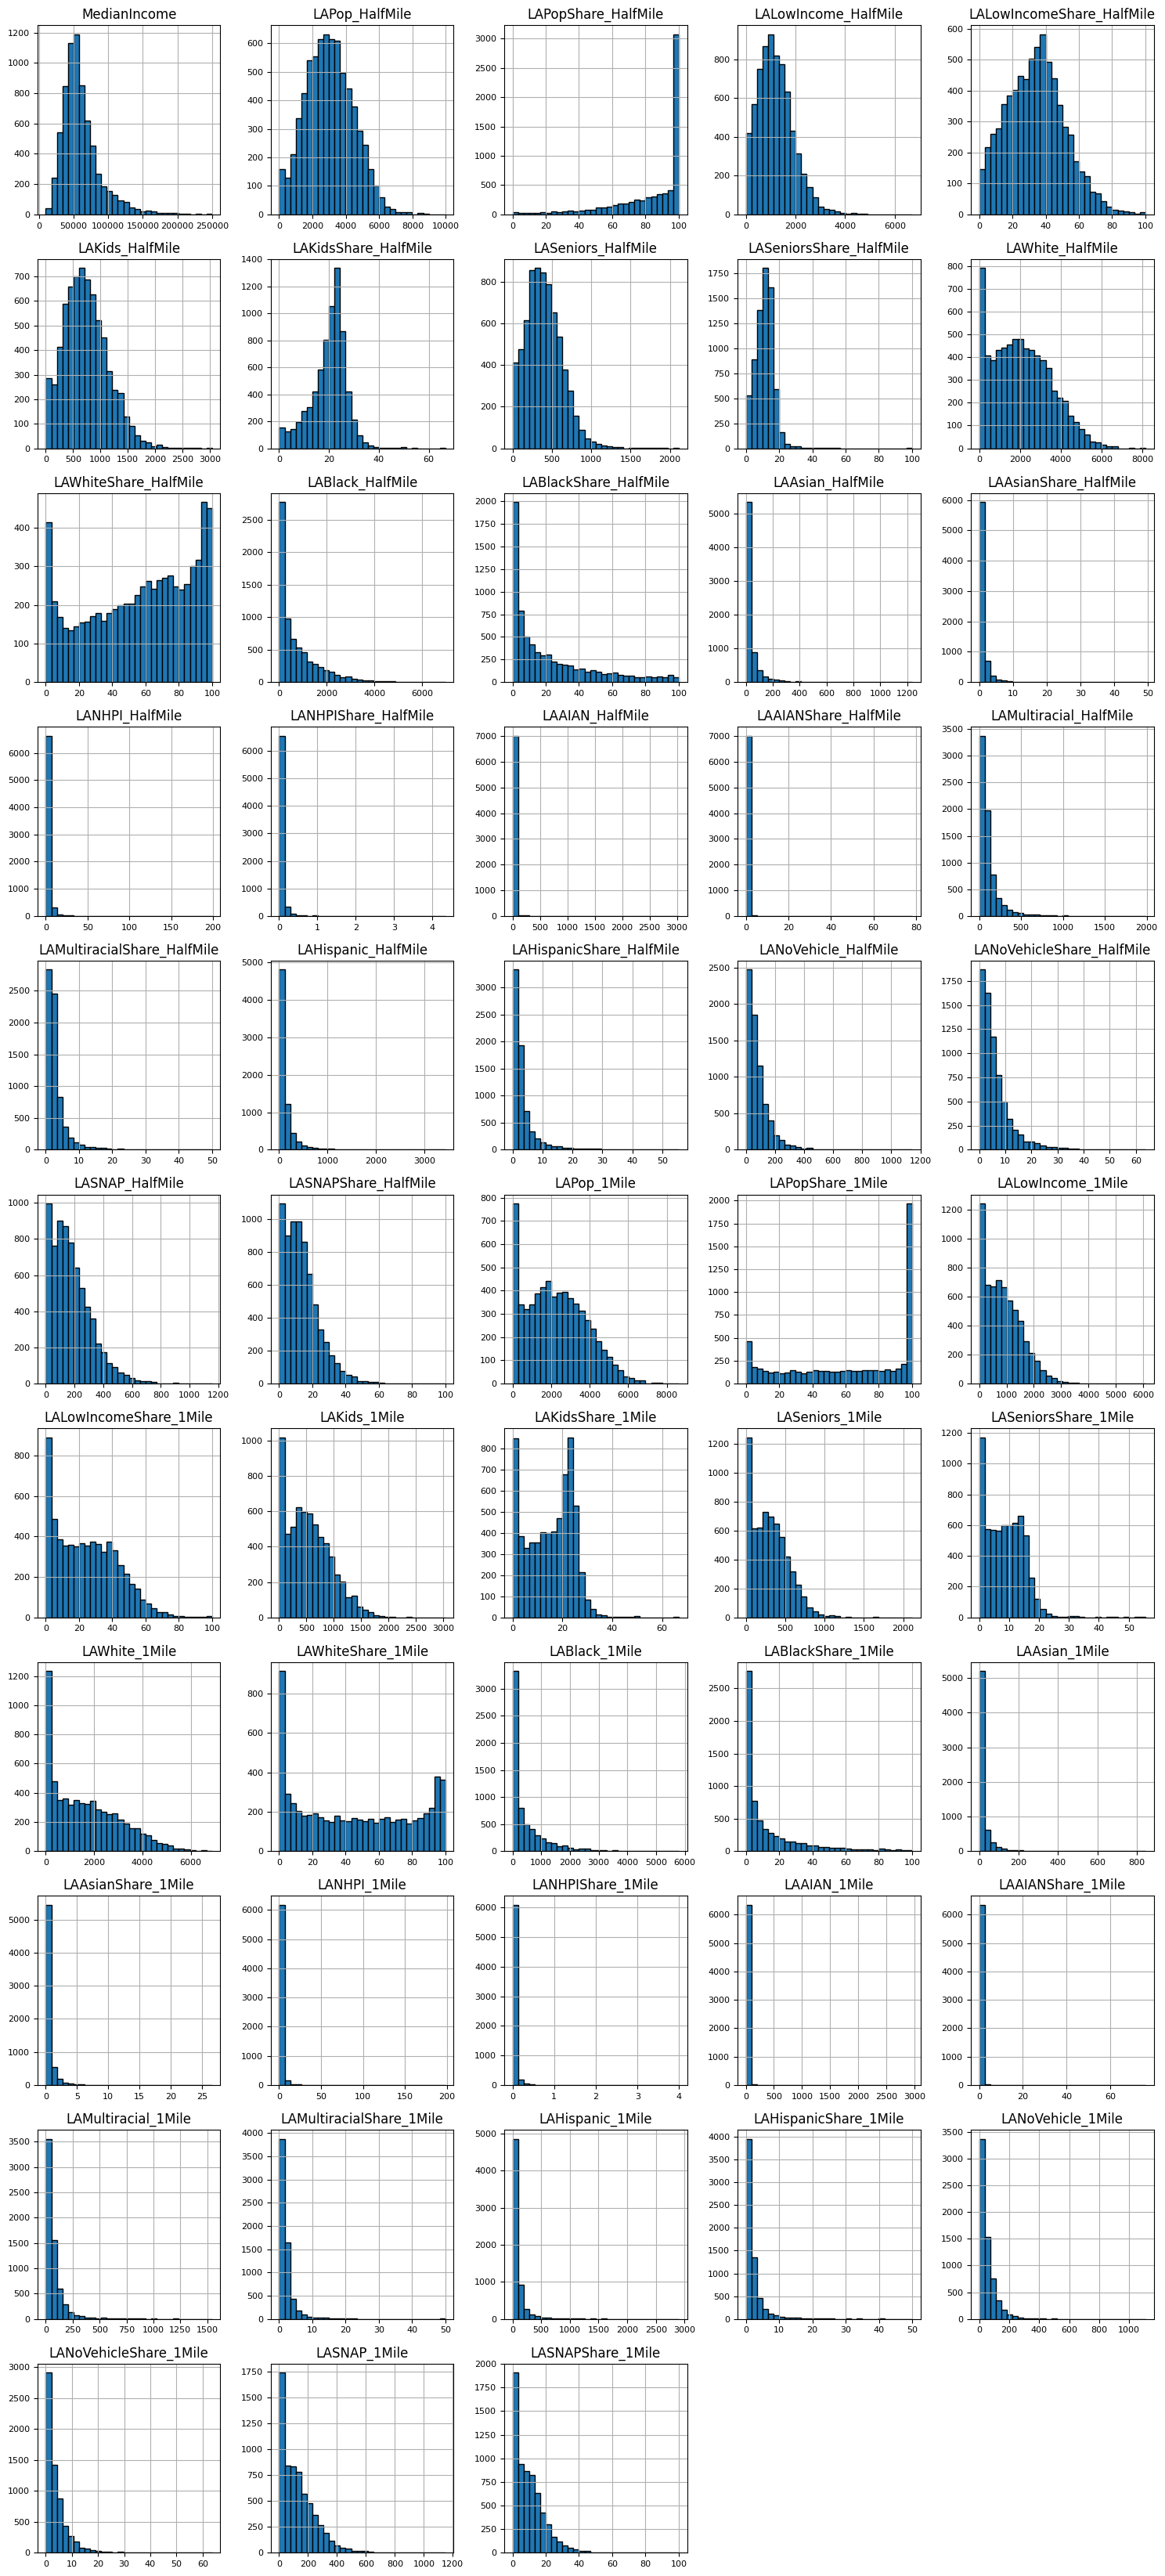

In [ ]:
# Filter columns with >0.6% missing
missing_values = df[df['Proportion of Missing Values'] > 0.006]
cols_to_plot = missing_values.index.tolist()

# Layout config
n_cols = 5
n_rows = int(np.ceil(len(cols_to_plot) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))  # 3 inches per row height
axes = axes.flatten()  # Flatten to iterate easily

# Plot histograms
for i, col in enumerate(cols_to_plot):
    centroids_data[col].dropna().plot(
        kind='hist',
        bins=30,
        ax=axes[i],
        edgecolor='black',
        title=col
    )
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(labelsize=8)
    axes[i].grid(True)

# Turn off extra axes if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [4]:
# Impute missing values using median number
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df = pd.DataFrame(centroids_data.isnull().sum(),
                      columns=['Missing Value Count'])
    df['Proportion of Missing Values'] = df['Missing Value Count'] / row_count
    cols_to_fill = df[df['Proportion of Missing Values'] > 0.006].index.tolist()

# Impute missing values of Median Income with median value
for col in cols_to_fill:
    centroids_data[col].fillna(centroids_data[col].median(), inplace=True)

# Check missing values again
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df = pd.DataFrame(centroids_data.isnull().sum(),
                      columns=['Missing Value Count'])
    df['Proportion of Missing Values'] = df['Missing Value Count'] / row_count
    print(df)


                             Missing Value Count  Proportion of Missing Values
IsUrban                                        0                           0.0
Pop2010                                        0                           0.0
OccupiedHousingUnits                           0                           0.0
HighGroupQuarters                              0                           0.0
GroupQuartersPopulation                        0                           0.0
GroupQuartersShare                             0                           0.0
LILA_UrbanHalf_Rural10                         0                           0.0
LILA_Urban1_Rural20                            0                           0.0
LILA_VehicleOr20Miles                          0                           0.0
LowVehicleAccess                               0                           0.0
IsLowIncome                                    0                           0.0
PovertyRate                                    0    

/tmp/ipython-input-4-268303762.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  centroids_data[col].fillna(centroids_data[col].median(), inplace=True)


Change all binary columns (0 and 1) to int type and all numeric columns to float type to more easily identify binary categorical and numeric columns.

In [5]:
# Change these columns to float type
to_float_cols = [
    "Pop2010",
    "OccupiedHousingUnits",
    "GroupQuartersPopulation",
    "LowIncomePopulation",
    "ChildPopulation",
    "SeniorPopulation",
    "WhitePopulation",
    "BlackPopulation",
    "AsianPopulation",
    "NHPIPopulation",
    "AIANPopulation",
    "MultiracialPopulation",
    "HispanicPopulation",
    "NoVehicleHouseholds",
    "SNAPRecipients"]
centroids_data[to_float_cols] = centroids_data[to_float_cols].astype(float)

# Print data types
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(centroids_data.dtypes)



IsUrban                          int64
Pop2010                        float64
OccupiedHousingUnits           float64
HighGroupQuarters                int64
GroupQuartersPopulation        float64
GroupQuartersShare             float64
LILA_UrbanHalf_Rural10           int64
LILA_Urban1_Rural20              int64
LILA_VehicleOr20Miles            int64
LowVehicleAccess                 int64
IsLowIncome                      int64
PovertyRate                    float64
MedianIncome                   float64
LA_Urban1_Rural10                int64
LA_UrbanHalf_Rural10             int64
LA_Urban1_Rural20                int64
LA_HalfMile                      int64
LA_1Mile                         int64
LA_10Miles                       int64
LA_20Miles                       int64
LA_VehicleOr20Miles              int64
LAPop_HalfMile                 float64
LAPopShare_HalfMile            float64
LALowIncome_HalfMile           float64
LALowIncomeShare_HalfMile      float64
LAKids_HalfMile          

### 1.3 Split Data


In [6]:
from sklearn.model_selection import train_test_split
np.random.seed(RANDOM_CODE)

# Shuffle the data
indices = np.arange(centroids_data.shape[0])
shuffled_indices = np.random.permutation(indices)
centroids_data = centroids_data.reindex(shuffled_indices)

# Split the data
y = centroids_data["IsFoodDesert"]
X = centroids_data.drop(columns=["IsFoodDesert"])
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_CODE)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=RANDOM_CODE)

# Print the shapes of the datasets
print('Transformed Data Overview:\n')
print('Data before transformation:')
for name, data in zip(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test'],
                   [X_train, y_train, X_val, y_val, X_test, y_test]):
    print(f'{name}: {data.shape}')

Transformed Data Overview:

Data before transformation:
X_train: (4272, 87)
y_train: (4272,)
X_val: (1424, 87)
y_val: (1424,)
X_test: (1425, 87)
y_test: (1425,)


### 1.4 Transform Data

- We have two kinds of data in the data set
    - Standard scale all numeric data
    - Pass through all binary categorical data

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Column Transformation
numeric_features = X_train.select_dtypes(include=['float64']).columns.tolist()
binary_features = X_train.select_dtypes(include=['int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features)
    ])

# After fitting the transformer
preprocessor.fit(X_train)

# Reconstruct column names
transformed_columns = []

# Loop through transformers
for name, transformer, cols in preprocessor.transformers_:
    if name != 'remainder':  # skip remainder if present
        if transformer == 'passthrough':
            # Passthrough keeps column names as is
            transformed_columns.extend(cols)
        elif hasattr(transformer, 'get_feature_names_out'):
            # Use feature names from transformer if available
            transformed_columns.extend(transformer.get_feature_names_out(cols))
        else:
            # If no feature names, fallback to raw col names
            transformed_columns.extend(cols)

# Apply transformation
X_train_scaled = preprocessor.transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# Create new DataFrames with correct columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=transformed_columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=transformed_columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=transformed_columns, index=X_test.index)


## <span style="color:chocolate">2. Baseline Model Building</span>

### 2.1 Outcome Distribution
The majority class is 0 (Not Food Desert), our baseline model is expected to have at least 77.27% accuracy so it's higher than random guessing as not food desert.

In [8]:
y_dist = pd.DataFrame(y_train.value_counts().values, columns=['Count'])
y_dist.index = ['Not Food Desert', 'Food Desert']
y_dist['Proportion'] = ((y_dist['Count'] / y_dist['Count'].sum()) * 100).round(2).astype(str)+'%'
y_dist

,Count,Proportion
Not Food Desert,3301,77.27%
Food Desert,971,22.73%


### 2.2 Dimensionality Reduction with PCA
- Since the top 20 components explain 93.55% of variability
- We re-refit PCA model with 20 components

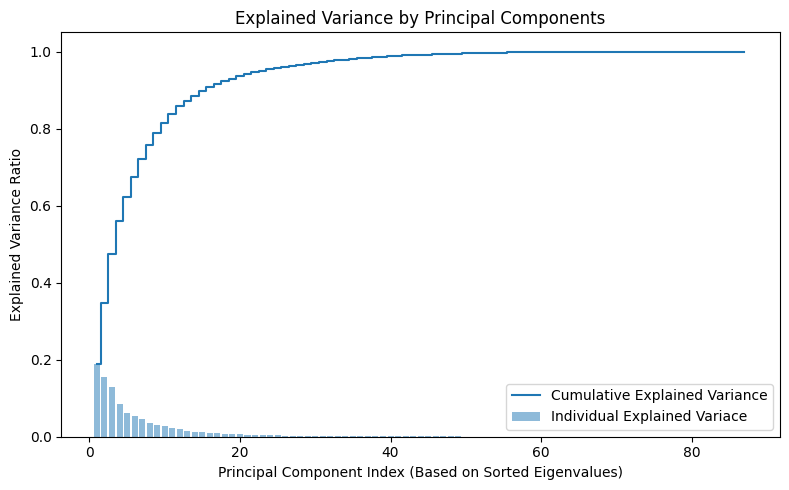

1 components: 18.98% variance explained
2 components: 34.61% variance explained
3 components: 47.41% variance explained
4 components: 56.02% variance explained
5 components: 62.12% variance explained
6 components: 67.41% variance explained
7 components: 72.07% variance explained
8 components: 75.66% variance explained
9 components: 78.82% variance explained
10 components: 81.51% variance explained
11 components: 83.85% variance explained
12 components: 85.75% variance explained
13 components: 87.25% variance explained
14 components: 88.59% variance explained
15 components: 89.72% variance explained
16 components: 90.70% variance explained
17 components: 91.55% variance explained
18 components: 92.29% variance explained
19 components: 92.95% variance explained
20 components: 93.54% variance explained
21 components: 94.09% variance explained
22 components: 94.57% variance explained
23 components: 94.97% variance explained
24 components: 95.36% variance explained
25 components: 95.68% var

In [9]:
from sklearn.decomposition import PCA

# PCA with all components
pca = PCA()
pca.fit_transform(X_train_scaled)

# Plot variance explained
plt.figure(figsize=(8, 5))

plt.bar(x=range(1, len(pca.explained_variance_ratio_)+1),
        height=pca.explained_variance_ratio_,
        alpha=0.5,
        align='center',
        label='Individual Explained Variace')

plt.step(x=range(1, len(pca.explained_variance_ratio_)+1),
         y=np.cumsum(pca.explained_variance_ratio_),
         where='mid',
         label='Cumulative Explained Variance')

plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component Index (Based on Sorted Eigenvalues)')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed variance information
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cumulative_variance, 1):
    print(f"{i} components: {var*100:.2f}% variance explained")


In [10]:
# Refit PCA with 20 components
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


### 2.3 Build Logistic Regerssion Model with TensorFlow and Tune the Model

In [ ]:
# !pip install keras-tuner


In [17]:
import tensorflow as tf
import keras_tuner as kt

# Build model tuner
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        kwargs['batch_size'] = hp.Choice('batch_size', [16, 32, 64, 128])

        # Build the model for this trial
        model = self.hypermodel.build(hp)

        # Train the model and capture the history
        history = model.fit(*args, **kwargs)

        # Repeat the final metrics back to the tuner
        self.oracle.update_trial(trial.trial_id, {
            'val_accuracy': history.history['val_accuracy'][-1],
            'accuracy': history.history['accuracy'][-1],
            'loss': history.history['loss'][-1]
        })

        return history

def model_builder(hp):
    tf.keras.backend.clear_session()
    tf.random.set_seed(RANDOM_CODE)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units=1,
        input_shape=(20,),
        activation='softmax'
    ))

    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def run_tuner_with_batch_size(batch_size):
    tuner.search(X_train_pca, y_train,
                 validation_data=(X_val_pca, y_val),
                 epochs=50,
                 batch_size=batch_size,
                 callbacks=[stop_early])

# Code Implementation
tf.keras.backend.clear_session()
tuner = MyTuner(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=20,
    directory='dir',
    project_name='logit_tuner'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              restore_best_weights=True)

tuner.search(X_train_pca, y_train,
             validation_data=(X_val_pca, y_val),
             epochs=50,
             callbacks=[stop_early])

# Train final model with the best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_pca, y_train,
                    validation_data=(X_val_pca, y_val),
                    epochs=50,
                    batch_size=best_hps.get('batch_size'),
                    callbacks=[stop_early],
                    verbose=0)


Trial 12 Complete [00h 00m 31s]
val_accuracy: 0.2008426934480667

Best val_accuracy So Far: 0.2008426934480667
Total elapsed time: 00h 06m 00s


In [18]:
# The first 5 learned parameters
weights, biases = model.layers[0].get_weights()  # weights: (2, 7), biases: (7,)
params_flat = np.concatenate([weights.flatten(), biases])
print("2. First five learned parameters (including biases):")
print(params_flat[:5])
print("Best batch size:", best_hps.get('batch_size'))


# Print final loss on train and val sets
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print(f"3. Final Training Loss: {train_loss:.4f} | Final Validation Loss: {val_loss:.4f}")

# Percentage differences
percent_diff = 100 * abs(train_loss - val_loss) / ((train_loss + val_loss) / 2)
print(f"4. Percentage difference between training and validation loss: {percent_diff:.2f}%")


2. First five learned parameters (including biases):
[ 0.17833754  0.43881845  0.09366567 -0.063682   -0.0581408 ]
Best batch size: 16
3. Final Training Loss: 0.2200 | Final Validation Loss: 0.2124
4. Percentage difference between training and validation loss: 3.55%


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Get predicted class probabilities
train_preds_prob = model.predict(X_train_pca)
test_preds_prob = model.predict(X_test_pca)

# Convert predicted probabilities to class labels
train_preds = np.argmax(train_preds_prob, axis=1)
test_preds = np.argmax(test_preds_prob, axis=1)

# Accuracy scores
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")



 80/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train Accuracy: 77.27%
Test Accuracy: 78.53%


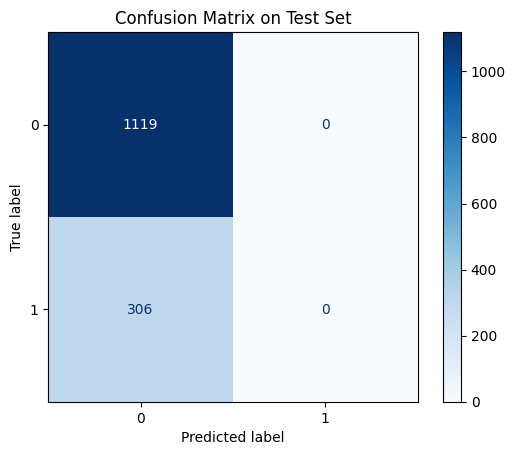

In [20]:
cm = confusion_matrix(y_test, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.show()